In [1]:
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# for data scaling and splitting
from sklearn.preprocessing import MinMaxScaler 
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
# for neural net
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras import regularizers
# for evaluation
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

Using TensorFlow backend.


In [2]:
data = pd.read_csv("data/combined_expression.csv")
data.head()

,CELL_LINE_NAME,cluster,TSPAN6,TNMD,DPM1,SCYL3,C1orf112,FGR,CFH,FUCA2,...,C6orf10,TMEM225,NOTCH4,PBX2,AGER,RNF5,AGPAT1,DFNB59,PRRT1,FKBPL
0,1240123,2,8.319417,3.111183,9.643558,4.757258,3.919757,3.602185,3.329644,9.076950,...,3.085394,3.462811,3.339030,4.614897,3.395845,3.419193,3.971646,3.729310,3.320022,6.447316
1,1240131,1,7.611268,2.704739,10.276079,3.650299,3.481567,3.145538,3.565127,7.861068,...,2.801456,2.985889,3.180068,5.415729,3.299858,3.028414,3.877889,3.911516,3.379405,4.729557
2,1240132,1,7.678658,2.845781,10.180954,3.573048,3.431235,3.090781,4.116643,8.121190,...,2.934962,2.952937,3.164655,5.707506,3.434295,2.961345,4.272194,3.085696,3.002557,5.653588
3,1240134,1,3.265063,3.063746,10.490285,3.340791,3.676912,3.512821,3.873922,8.790851,...,3.041839,3.398847,3.106710,5.773963,3.412641,3.136110,4.422262,3.522122,3.509437,5.953242
4,1240140,1,7.090138,2.988043,10.264692,4.119555,3.432585,3.308033,3.318371,6.927761,...,3.028787,3.225982,3.275820,5.334283,3.864678,3.259242,3.840581,5.809553,3.674587,5.577503


In [3]:
data['cluster'].replace([1, 2],[0, 1],inplace=True)
data.shape

(541, 16384)

In [4]:
selected_genes = pd.read_csv('cleaned/boruta.csv')
selected_genes = selected_genes.values.tolist()
selected_genes = list(itertools.chain(*selected_genes))
len(selected_genes)

300

In [5]:
# retrieving proper columns
X = data.loc[:, selected_genes]
y = data['cluster'].values
# scaling the data
scalar = MinMaxScaler()
x_scaled = scalar.fit_transform(X)
# splitting data (20% test, 80% train)
X_train, X_test, y_train, y_test = train_test_split(x_scaled, y, test_size=0.2)
sm = SMOTE()
X_train, y_train = sm.fit_sample(X_train, y_train)

# Confusion Matrix Plotting Function

In [6]:
def plot_confusion_matrix(cm, target_names, title='Confusion matrix', cmap=None, normalize=True, cbar=True):
    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    fig = plt.figure(figsize=(4, 3), dpi=200)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names)
        plt.yticks(tick_marks, target_names, rotation=90, verticalalignment='center')
#         plt.yticks([], ['', ''])

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
    if cbar:
        plt.colorbar()

    plt.tight_layout()
    plt.ylabel('True')
    plt.xlabel('Predicted\naccuracy={:0.3f}; misclass={:0.3f}'.format(accuracy, misclass))
    plt.show()

    return fig

# 1 Hidden Layer

In [7]:
def hidden1(optimizer='sgd', init='normal', dropout=0.3, neurons=100):
    model = Sequential()
    hidden_layers = len(selected_genes)
    # add 1 hidden layer
    model.add(Dense(neurons, activation='relu', kernel_regularizer=regularizers.l2(1e-3)))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))

    model.add(Dense(1, activation='sigmoid'))
    # compiling
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [8]:
model1 = KerasClassifier(build_fn=hidden1, epochs=25, batch_size=16)

In [9]:
history1 = model1.fit(X_train, y_train, validation_data=(X_test,y_test), shuffle=True)
y_pred1 = model1.predict(X_test)

Train on 562 samples, validate on 109 samples
Epoch 1/25
562/562 [==============================] - 2s 3ms/sample - loss: 0.5764 - accuracy: 0.8221 - val_loss: 0.5967 - val_accuracy: 0.8532
Epoch 2/25
562/562 [==============================] - 0s 323us/sample - loss: 0.5695 - accuracy: 0.8078 - val_loss: 0.5775 - val_accuracy: 0.8807
Epoch 3/25
562/562 [==============================] - 0s 345us/sample - loss: 0.4827 - accuracy: 0.8577 - val_loss: 0.5763 - val_accuracy: 0.8532
Epoch 4/25
562/562 [==============================] - 0s 345us/sample - loss: 0.4728 - accuracy: 0.8719 - val_loss: 0.5668 - val_accuracy: 0.8532
Epoch 5/25
562/562 [==============================] - 0s 337us/sample - loss: 0.4583 - accuracy: 0.8737 - val_loss: 0.5522 - val_accuracy: 0.8440
Epoch 6/25
562/562 [==============================] - 0s 337us/sample - loss: 0.4332 - accuracy: 0.8915 - val_loss: 0.6008 - val_accuracy: 0.8073
Epoch 7/25
562/562 [==============================] - 0s 336us/sample - loss: 0.

In [10]:
print(classification_report(y_test, y_pred1))

              precision    recall  f1-score   support

           0       0.86      0.92      0.88        71
           1       0.82      0.71      0.76        38

    accuracy                           0.84       109
   macro avg       0.84      0.81      0.82       109
weighted avg       0.84      0.84      0.84       109



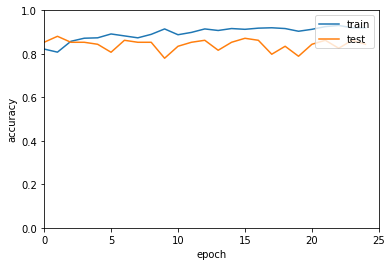

In [11]:
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.ylim(0, 1)
plt.xlim(0, 25)
plt.show()

Text(0.5, 0, 'epoch')

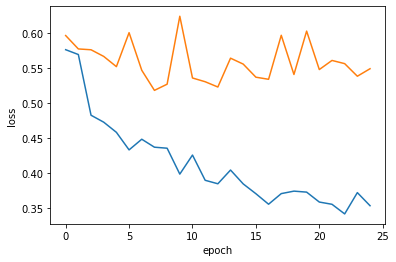

In [12]:
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')

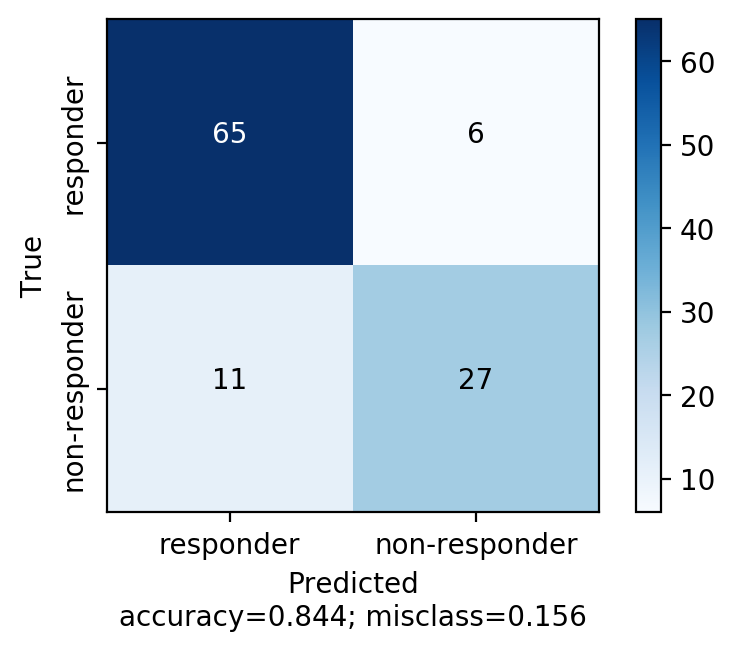

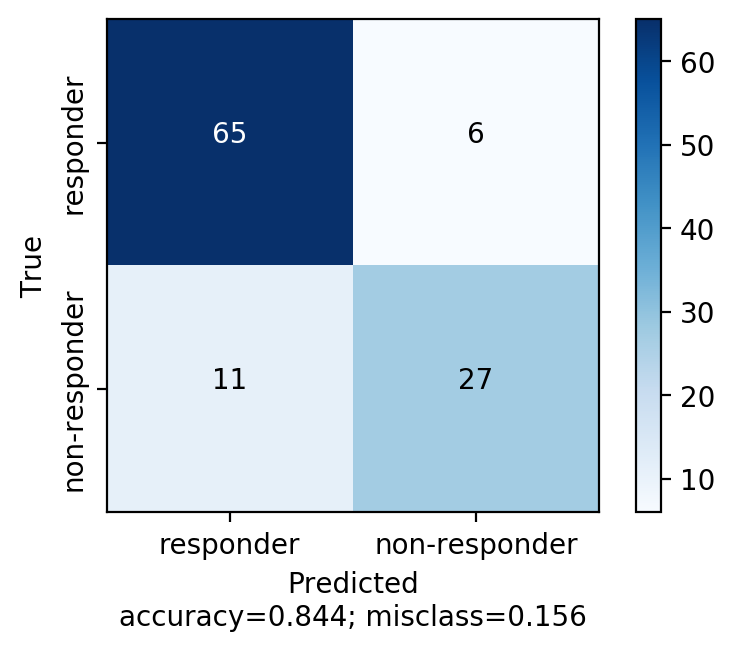

In [13]:
cm = confusion_matrix(y_test, y_pred1)
plot_confusion_matrix(cm, ['responder', 'non-responder'], title='', normalize=False)

In [14]:
model1.model.save('models/hidden1/')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: models/hidden1/assets


# 5 Hidden Layers

In [15]:
def hidden5(optimizer='sgd', init='normal', dropout=0.3, neurons=100):
    model = Sequential()
    hidden_layers = len(selected_genes)
    # add 5 hidden layers
    for i in range(5):
        model.add(Dense(neurons, activation='relu', kernel_regularizer=regularizers.l2(1e-3)))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

    model.add(Dense(1, activation='sigmoid'))
    # compiling
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [16]:
model5 = KerasClassifier(build_fn=hidden5, epochs=25, batch_size=16)

In [17]:
history5 = model5.fit(X_train, y_train, validation_data=(X_test,y_test), shuffle=True)
y_pred5 = model5.predict(X_test)

Train on 562 samples, validate on 109 samples
Epoch 1/25
562/562 [==============================] - 4s 7ms/sample - loss: 1.2537 - accuracy: 0.6495 - val_loss: 8.9046 - val_accuracy: 0.3394
Epoch 2/25
562/562 [==============================] - 0s 838us/sample - loss: 1.8290 - accuracy: 0.6851 - val_loss: 1.9235 - val_accuracy: 0.4679
Epoch 3/25
562/562 [==============================] - 0s 861us/sample - loss: 1.8034 - accuracy: 0.7384 - val_loss: 1.7294 - val_accuracy: 0.7706
Epoch 4/25
562/562 [==============================] - 0s 849us/sample - loss: 1.7146 - accuracy: 0.7722 - val_loss: 1.7627 - val_accuracy: 0.7339
Epoch 5/25
562/562 [==============================] - 0s 849us/sample - loss: 1.6863 - accuracy: 0.7972 - val_loss: 1.7069 - val_accuracy: 0.8532
Epoch 6/25
562/562 [==============================] - 0s 854us/sample - loss: 1.6980 - accuracy: 0.8025 - val_loss: 1.6842 - val_accuracy: 0.8624
Epoch 7/25
562/562 [==============================] - 0s 862us/sample - loss: 1.

In [18]:
print(classification_report(y_test, y_pred5))

              precision    recall  f1-score   support

           0       0.87      0.93      0.90        71
           1       0.85      0.74      0.79        38

    accuracy                           0.86       109
   macro avg       0.86      0.83      0.84       109
weighted avg       0.86      0.86      0.86       109



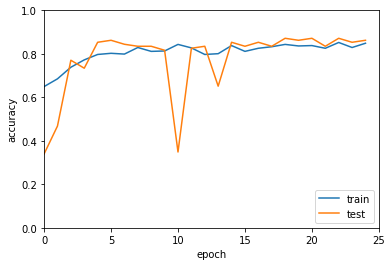

In [19]:
plt.plot(history5.history['accuracy'])
plt.plot(history5.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.ylim(0, 1)
plt.xlim(0, 25)
plt.show()

Text(0.5, 0, 'epoch')

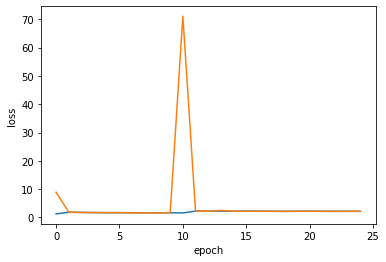

In [20]:
plt.plot(history5.history['loss'])
plt.plot(history5.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')

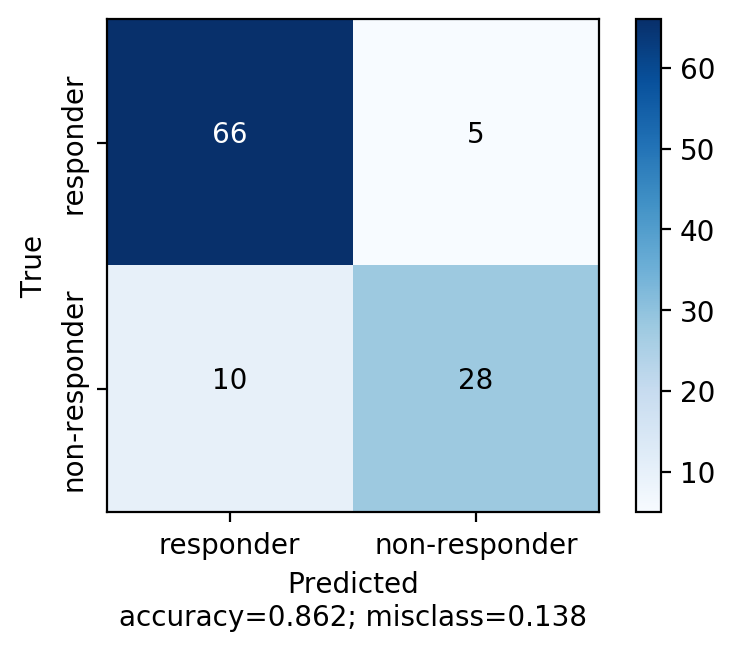

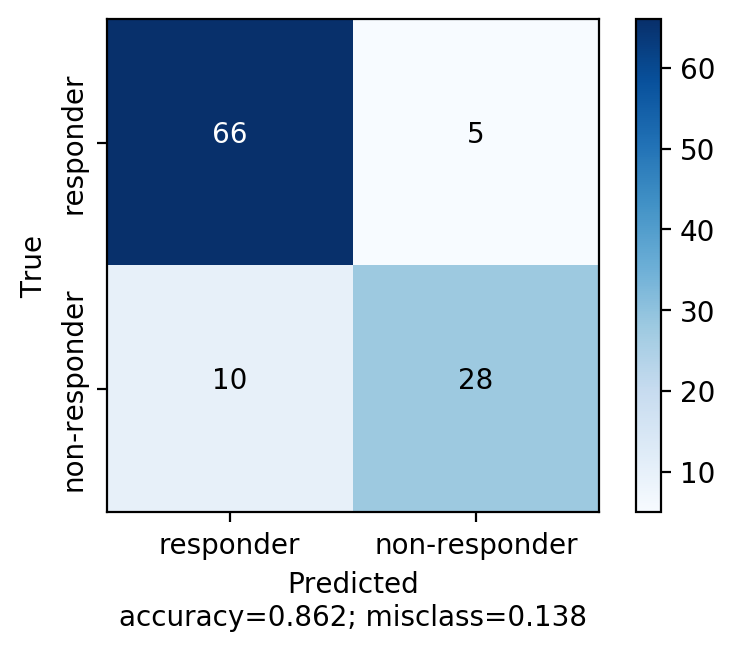

In [21]:
cm = confusion_matrix(y_test, y_pred5)
plt.rcParams.update({'font.size': 10})
plot_confusion_matrix(cm, ['responder', 'non-responder'], title='', normalize=False)

In [22]:
model5.model.save('models/hidden5/')

INFO:tensorflow:Assets written to: models/hidden5/assets


# 10 Hidden Layers

In [23]:
def hidden10(optimizer='sgd', init='normal', dropout=0.3, neurons=100):
    model = Sequential()
    hidden_layers = len(selected_genes)
    # add 10 hidden layers
    for i in range(10):
        model.add(Dense(neurons, activation='relu', kernel_regularizer=regularizers.l2(1e-3)))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

    model.add(Dense(1, activation='sigmoid'))
    # compiling
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [24]:
model10 = KerasClassifier(build_fn=hidden10, epochs=25, batch_size=16)

In [25]:
history10 = model10.fit(X_train, y_train, validation_data=(X_test, y_test), shuffle=True)
y_pred10 = model10.predict(X_test)

Train on 562 samples, validate on 109 samples
Epoch 1/25
562/562 [==============================] - 7s 12ms/sample - loss: 2.0021 - accuracy: 0.5160 - val_loss: 3.5740 - val_accuracy: 0.7339
Epoch 2/25
562/562 [==============================] - 1s 1ms/sample - loss: 3.7971 - accuracy: 0.5285 - val_loss: 3.5020 - val_accuracy: 0.8899
Epoch 3/25
562/562 [==============================] - 1s 2ms/sample - loss: 3.7258 - accuracy: 0.5783 - val_loss: 4.3485 - val_accuracy: 0.3486
Epoch 4/25
562/562 [==============================] - 1s 2ms/sample - loss: 3.8765 - accuracy: 0.6690 - val_loss: 8923.0367 - val_accuracy: 0.6514
Epoch 5/25
562/562 [==============================] - 1s 2ms/sample - loss: 1611.5110 - accuracy: 0.5196 - val_loss: 1621.4976 - val_accuracy: 0.6514
Epoch 6/25
562/562 [==============================] - 1s 2ms/sample - loss: 1609.8736 - accuracy: 0.5694 - val_loss: 1610.2692 - val_accuracy: 0.6514
Epoch 7/25
562/562 [==============================] - 1s 2ms/sample - loss

In [26]:
print(classification_report(y_test, y_pred10))

              precision    recall  f1-score   support

           0       0.85      0.90      0.88        71
           1       0.79      0.71      0.75        38

    accuracy                           0.83       109
   macro avg       0.82      0.81      0.81       109
weighted avg       0.83      0.83      0.83       109



In [27]:
print(confusion_matrix(y_test, y_pred10))

[[64  7]
 [11 27]]


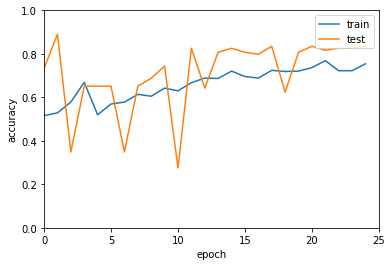

In [28]:
plt.plot(history10.history['accuracy'])
plt.plot(history10.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.ylim(0, 1)
plt.xlim(0, 25)
plt.show()

Text(0.5, 0, 'epoch')

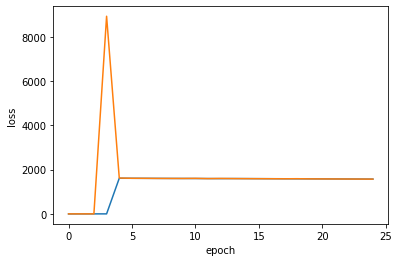

In [29]:
plt.plot(history10.history['loss'])
plt.plot(history10.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')

In [30]:
model10.model.save('models/hidden10/')

INFO:tensorflow:Assets written to: models/hidden10/assets


# 15 Hidden Layers

In [31]:
def hidden15(optimizer='sgd', init='normal', dropout=0.3, neurons=100):
    model = Sequential()
    hidden_layers = len(selected_genes)
    # add 15 hidden layers
    for i in range(15):
        model.add(Dense(neurons, activation='relu', kernel_regularizer=regularizers.l2(1e-3)))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

    model.add(Dense(1, activation='sigmoid'))
    # compiling
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [32]:
model15 = KerasClassifier(build_fn=hidden15, epochs=25, batch_size=16)

In [33]:
history15 = model15.fit(X_train, y_train, validation_data=(X_test, y_test), shuffle=True)
y_pred15 = model15.predict(X_test)

Train on 562 samples, validate on 109 samples
Epoch 1/25
562/562 [==============================] - 10s 17ms/sample - loss: 2.5493 - accuracy: 0.4804 - val_loss: 993441894878271099633664.0000 - val_accuracy: 0.6514
Epoch 2/25
562/562 [==============================] - 1s 2ms/sample - loss: 101220.9535 - accuracy: 0.5730 - val_loss: 101152.3965 - val_accuracy: 0.6514
Epoch 3/25
562/562 [==============================] - 1s 2ms/sample - loss: 101075.3227 - accuracy: 0.5641 - val_loss: 101005.8271 - val_accuracy: 0.3486
Epoch 4/25
562/562 [==============================] - 1s 2ms/sample - loss: 100930.3212 - accuracy: 0.6068 - val_loss: 102007.8501 - val_accuracy: 0.1376
Epoch 5/25
562/562 [==============================] - 1s 2ms/sample - loss: 100875.7955 - accuracy: 0.5979 - val_loss: 100799.4933 - val_accuracy: 0.3486
Epoch 6/25
562/562 [==============================] - 1s 3ms/sample - loss: 100730.5961 - accuracy: 0.5996 - val_loss: 100654.1537 - val_accuracy: 0.8991
Epoch 7/25
562/

In [34]:
print(classification_report(y_test, y_pred15))

              precision    recall  f1-score   support

           0       0.85      0.97      0.91        71
           1       0.93      0.68      0.79        38

    accuracy                           0.87       109
   macro avg       0.89      0.83      0.85       109
weighted avg       0.88      0.87      0.87       109



In [35]:
print(confusion_matrix(y_test, y_pred15))

[[69  2]
 [12 26]]


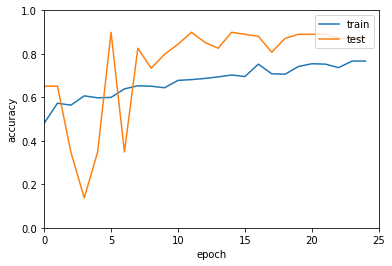

In [36]:
plt.plot(history15.history['accuracy'])
plt.plot(history15.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.ylim(0, 1)
plt.xlim(0, 25)
plt.show()

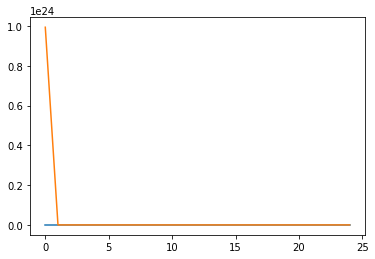

In [37]:
plt.plot(history15.history['loss'])
plt.plot(history15.history['val_loss'])

In [38]:
model15.model.save('models/hidden15/')

INFO:tensorflow:Assets written to: models/hidden15/assets
